# Used Cars Analysis Pipeline - Pandas
## 04. Time Series Analysis and Forecasting

### Objectives:
1. Temporal feature engineering
2. Trend and seasonality analysis
3. Sales forecasting with ARIMA/Prophet
4. Model evaluation

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

from src.utils.pandas_utils import load_config, create_time_features

# For time series modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Setup complete")

✅ Setup complete


In [2]:
# Load cleaned dataset
cleaned_path = os.path.join(project_root, 'data', 'cleaned', 'superstore_cleaned.csv')
df = pd.read_csv(cleaned_path)

print(f"📊 Dataset shape: {df.shape}")

# Convert date columns
date_cols = [col for col in df.columns if 'date' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"✅ Converted {col} to datetime")

print(f"\nDate range: {df[date_cols[0]].min()} to {df[date_cols[0]].max()}")

📊 Dataset shape: (9800, 18)
✅ Converted Order_Date to datetime
✅ Converted Ship_Date to datetime

Date range: 2015-01-02 00:00:00 to 2018-12-11 00:00:00


In [3]:
# Create time-based aggregation
print("\n" + "="*70)
print("TIME SERIES AGGREGATION")
print("="*70)

# Assume first date column is order date
date_col = date_cols[0] if date_cols else 'Order Date'

# Daily sales
daily_sales = df.groupby(pd.Grouper(key=date_col, freq='D'))['Sales'].sum().reset_index()
daily_sales.columns = ['Date', 'Sales']
daily_sales = daily_sales[daily_sales['Sales'] > 0]  # Remove zero days

print(f"\nDaily sales records: {len(daily_sales)}")
print(f"Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")
print(f"\nSample data:")
print(daily_sales.head())


TIME SERIES AGGREGATION

Daily sales records: 479
Date range: 2015-01-02 00:00:00 to 2018-12-11 00:00:00

Sample data:
        Date      Sales
0 2015-01-02   468.9000
1 2015-01-03  2069.6755
2 2015-01-04   119.8880
4 2015-01-06  2303.4015
5 2015-01-07   525.7445


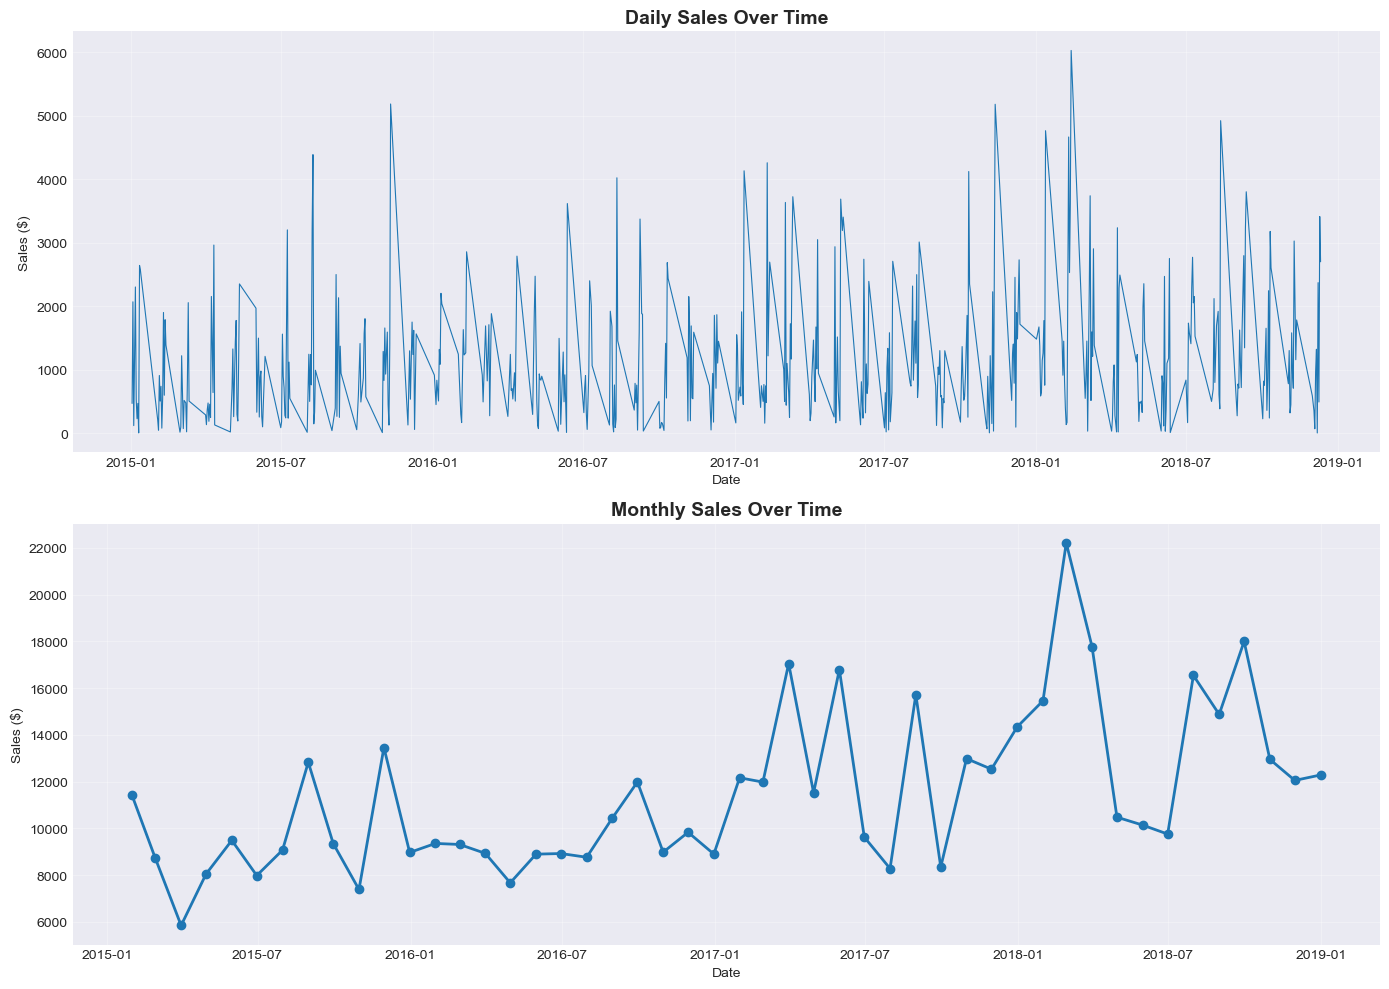

In [4]:
# Visualize time series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Daily sales
axes[0].plot(daily_sales['Date'], daily_sales['Sales'], linewidth=0.8)
axes[0].set_title('Daily Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales ($)')
axes[0].grid(True, alpha=0.3)

# Monthly sales (smoother)
monthly_sales = daily_sales.set_index('Date').resample('M')['Sales'].sum()
axes[1].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2)
axes[1].set_title('Monthly Sales Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'time_series_pandas.png'), dpi=300)
plt.show()


SEASONAL DECOMPOSITION


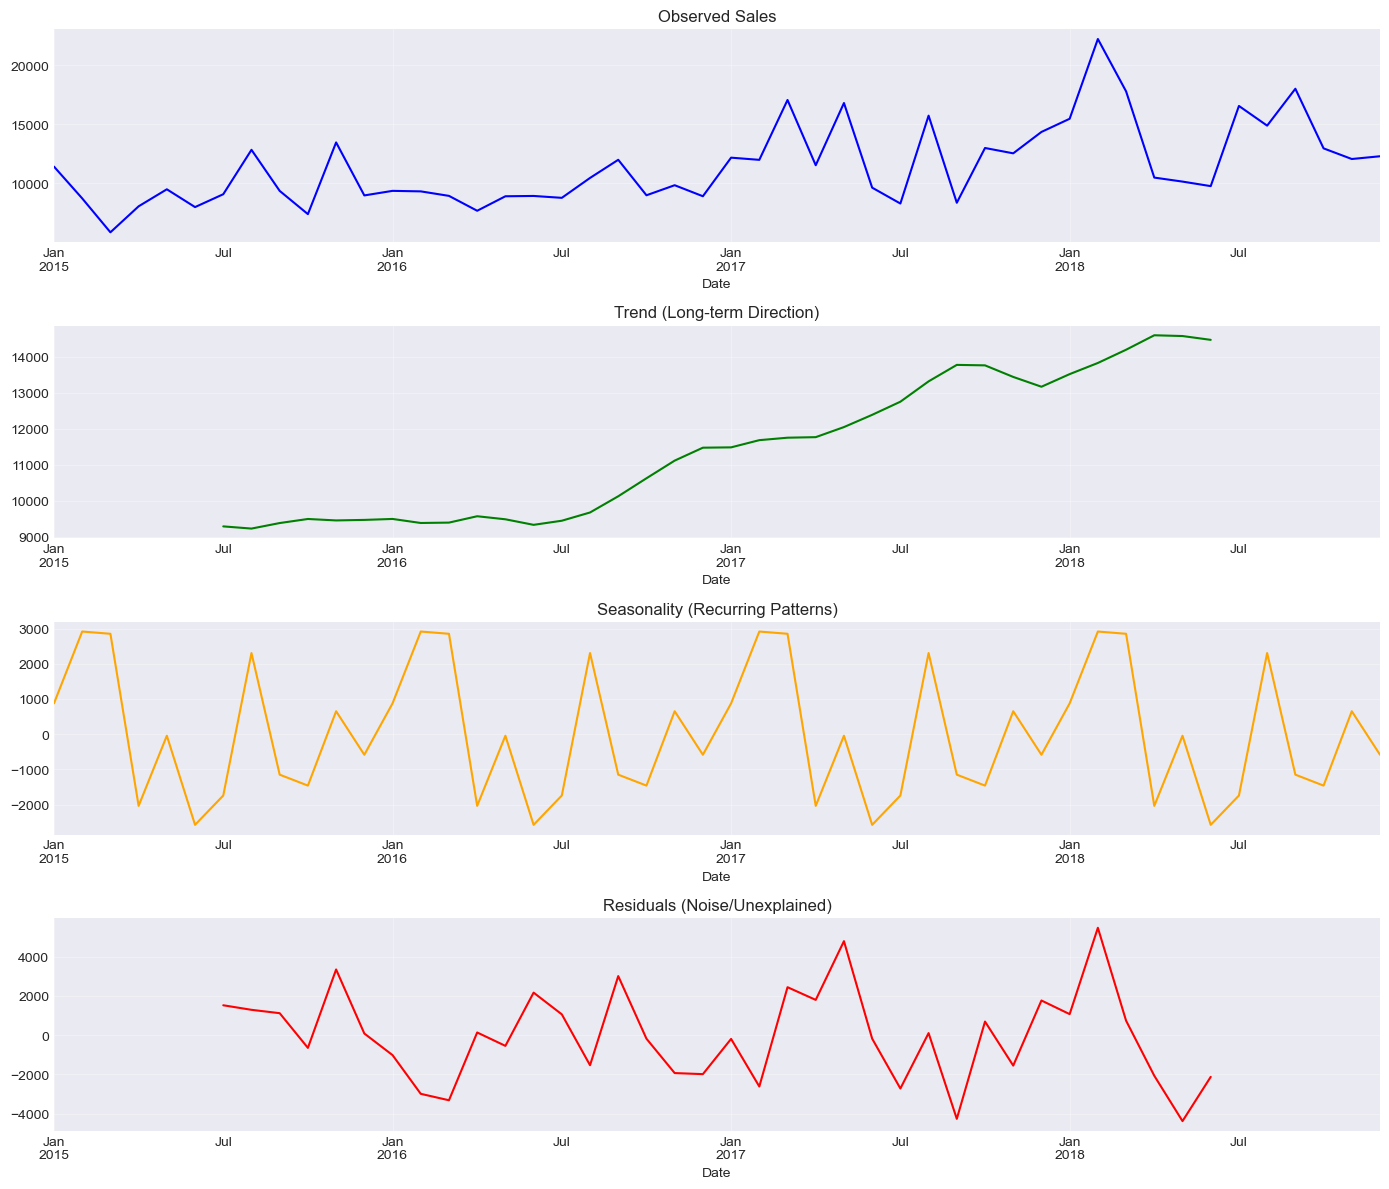

✅ Seasonal decomposition complete using inferred frequency


In [5]:
print("\n" + "="*70)
print("SEASONAL DECOMPOSITION")
print("="*70)

ts_data = monthly_sales.copy()

if not isinstance(ts_data.index, pd.DatetimeIndex):
    ts_data.index = ts_data.index.to_timestamp()

ts_data.index.freq = ts_data.index.inferred_freq

if ts_data.index.freq is None:
    ts_data = ts_data.asfreq('ME')

decomposition = seasonal_decompose(ts_data, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=axes[0], title='Observed Sales', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend (Long-term Direction)', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality (Recurring Patterns)', color='orange')
decomposition.resid.plot(ax=axes[3], title='Residuals (Noise/Unexplained)', color='red')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'seasonal_decomposition_pandas.png'), dpi=300)
plt.show()

print("✅ Seasonal decomposition complete using inferred frequency")

In [6]:
# Stationarity test
print("\n" + "="*70)
print("STATIONARITY TEST (Augmented Dickey-Fuller)")
print("="*70)

result = adfuller(ts_data.dropna())

print(f"\nADF Statistic: {result[0]:.6f}")
print(f"P-value: {result[1]:.6f}")
print(f"\nCritical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")

if result[1] < 0.05:
    print("\n✅ Series is STATIONARY (p < 0.05)")
else:
    print("\n⚠️  Series is NON-STATIONARY (p >= 0.05)")
    print("   Consider differencing or transformation")


STATIONARITY TEST (Augmented Dickey-Fuller)

ADF Statistic: -4.217149
P-value: 0.000616

Critical Values:
  1%: -3.578
  5%: -2.925
  10%: -2.601

✅ Series is STATIONARY (p < 0.05)


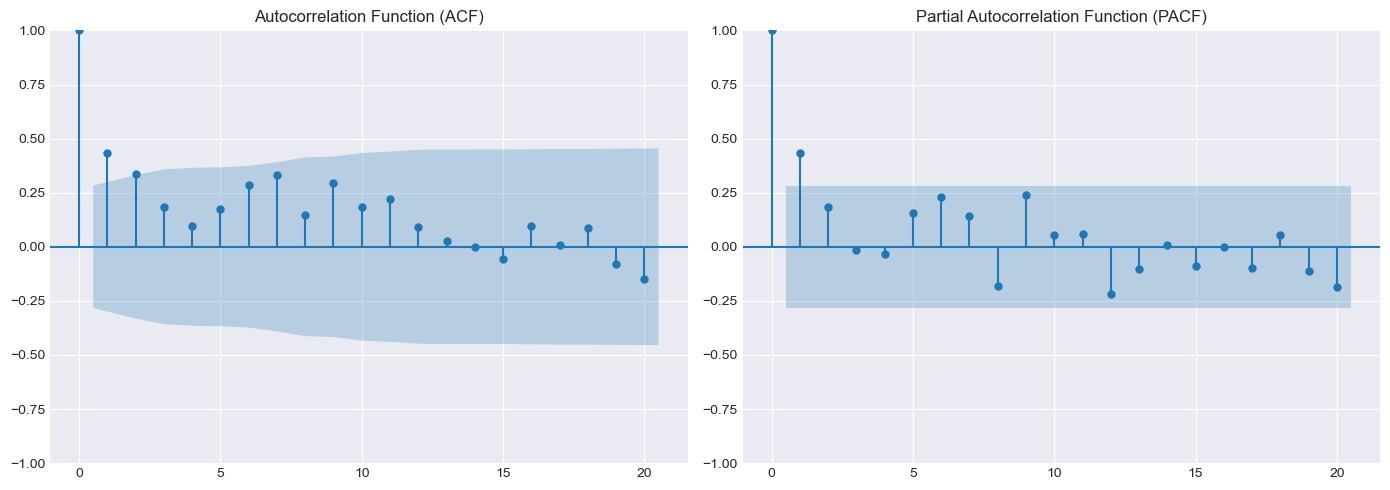


✅ ACF/PACF analysis complete


In [7]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(ts_data.dropna(), lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(ts_data.dropna(), lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'acf_pacf_pandas.png'), dpi=300)
plt.show()

print("\n✅ ACF/PACF analysis complete")


SIMPLE FORECASTING - MOVING AVERAGE


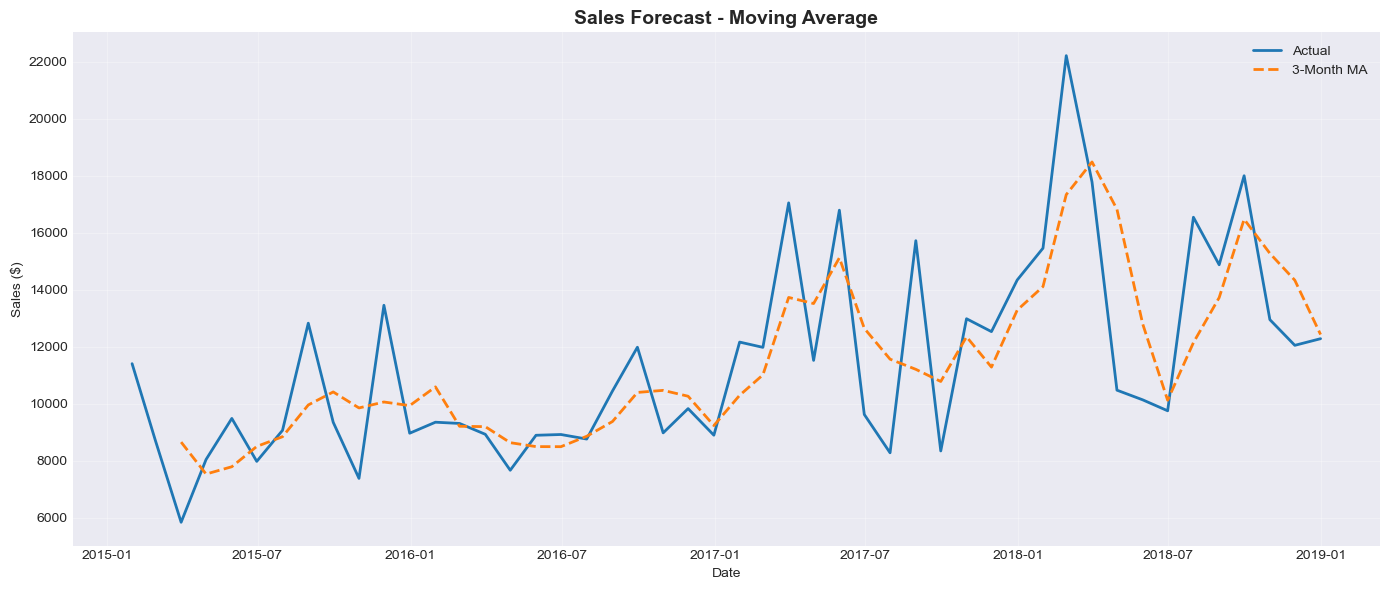

✅ Moving average forecast complete


In [8]:
# Simple forecasting with moving average
print("\n" + "="*70)
print("SIMPLE FORECASTING - MOVING AVERAGE")
print("="*70)

# 3-month moving average
ts_data_ma = ts_data.rolling(window=3).mean()

plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data.values, label='Actual', linewidth=2)
plt.plot(ts_data_ma.index, ts_data_ma.values, label='3-Month MA', linewidth=2, linestyle='--')
plt.title('Sales Forecast - Moving Average', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'forecast_ma_pandas.png'), dpi=300)
plt.show()

print("✅ Moving average forecast complete")

In [9]:
# Summary statistics
print("\n" + "="*70)
print("TIME SERIES SUMMARY")
print("="*70)

print(f"\n📊 Key Metrics:")
print(f"  • Average daily sales: ${daily_sales['Sales'].mean():,.2f}")
print(f"  • Average monthly sales: ${monthly_sales.mean():,.2f}")
print(f"  • Peak sales month: {monthly_sales.idxmax().strftime('%Y-%m')} (${monthly_sales.max():,.2f})")
print(f"  • Lowest sales month: {monthly_sales.idxmin().strftime('%Y-%m')} (${monthly_sales.min():,.2f})")
print(f"  • Sales volatility (std): ${monthly_sales.std():,.2f}")

# Growth trend
first_6m = monthly_sales.iloc[:6].mean()
last_6m = monthly_sales.iloc[-6:].mean()
growth = ((last_6m - first_6m) / first_6m) * 100

print(f"\n📈 Growth Analysis:")
print(f"  • First 6 months avg: ${first_6m:,.2f}")
print(f"  • Last 6 months avg: ${last_6m:,.2f}")
print(f"  • Growth rate: {growth:+.2f}%")

print("\n✅ Time series analysis complete!")


TIME SERIES SUMMARY

📊 Key Metrics:
  • Average daily sales: $1,144.94
  • Average monthly sales: $11,425.50
  • Peak sales month: 2018-02 ($22,208.94)
  • Lowest sales month: 2015-03 ($5,847.38)
  • Sales volatility (std): $3,408.76

📈 Growth Analysis:
  • First 6 months avg: $8,581.85
  • Last 6 months avg: $14,450.69
  • Growth rate: +68.39%

✅ Time series analysis complete!
